In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Initialize lists to store x and y coordinates
x_coords = []
y_coords = []

def onclick(event):
    # Check if the click is within the axes
    if event.inaxes:
        x, y = event.xdata, event.ydata
        x_coords.append(x)
        y_coords.append(y)
        # Plot the selected point
        event.inaxes.plot(x, y, 'ro')
        plt.draw()

# Create a figure and axis with a grid
fig, ax = plt.subplots()
ax.grid(True)
ax.set_title('Click to select points on the grid')

# Connect the click event handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()


In [5]:
import ipywidgets as widgets
from IPython.display import display

done_button = widgets.Button(description="Done Selecting Points")

def on_done_button_clicked(b):
    # Disconnect the click event handler
    fig.canvas.mpl_disconnect(cid)
    plt.close(fig)
    # Proceed to Fourier analysis
    process_points()

done_button.on_click(on_done_button_clicked)
display(done_button)

In [6]:
import numpy as np

def process_points():
    # Ensure the x-values are sorted
    sorted_indices = np.argsort(x_coords)
    x_sorted = np.array(x_coords)[sorted_indices]
    y_sorted = np.array(y_coords)[sorted_indices]

    # Interpolate to get evenly spaced x-values
    num_points = 1000  # Number of points for smooth curve
    x_even = np.linspace(x_sorted[0], x_sorted[-1], num_points)
    y_even = np.interp(x_even, x_sorted, y_sorted)

    # Perform Fourier Transform
    y_fft = np.fft.fft(y_even)
    freq = np.fft.fftfreq(num_points, d=(x_even[1] - x_even[0]))

    # Filter to keep only significant frequencies (optional)
    threshold = np.max(np.abs(y_fft)) * 0.05
    y_fft_filtered = y_fft.copy()
    y_fft_filtered[np.abs(y_fft) < threshold] = 0

    # Inverse FFT to get the smoothed curve
    y_smooth = np.fft.ifft(y_fft_filtered)

    # Plot the Fourier curve
    plt.figure()
    plt.plot(x_even, y_smooth.real, label='Fourier Curve')
    plt.plot(x_coords, y_coords, 'ro', label='Selected Points')
    plt.legend()
    plt.grid(True)
    plt.title('Fourier Curve Fit')
    plt.show()


Button(description='Done Selecting Points', style=ButtonStyle())

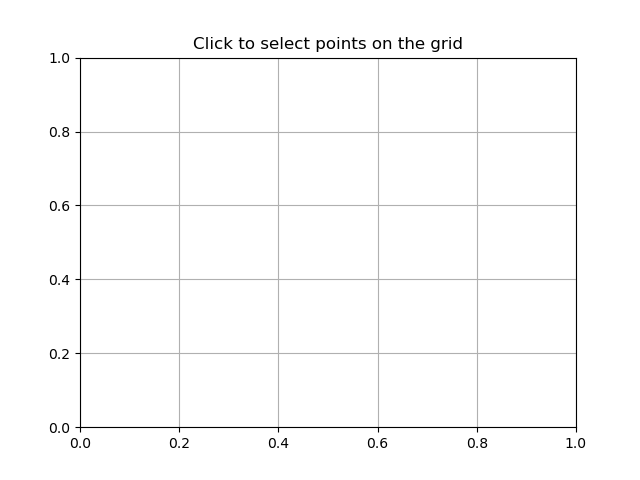

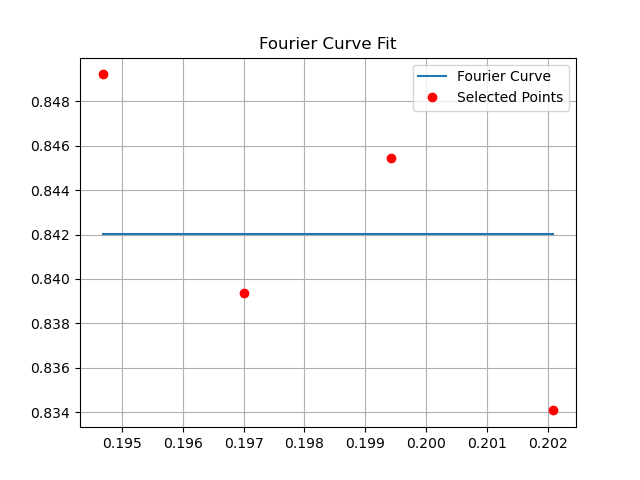

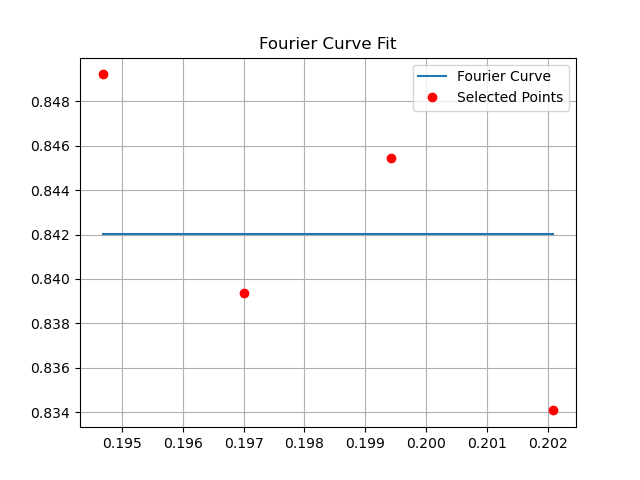

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to handle point selection
def interactive_fourier_curve():
    # Clear previous output
    clear_output(wait=True)

    # Initialize lists to store x and y coordinates
    x_coords = []
    y_coords = []

    # Create a figure and axis with a grid
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_title('Click to select points on the grid')

    # Function to handle click events
    def onclick(event):
        if event.inaxes:
            x, y = event.xdata, event.ydata
            x_coords.append(x)
            y_coords.append(y)
            event.inaxes.plot(x, y, 'ro')
            fig.canvas.draw()

    # Connect the click event handler
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

    # Function to process points and plot Fourier curve
    def process_points(b):
        # Disconnect the click event handler
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)

        # Ensure there are enough points
        if len(x_coords) < 2:
            print("Please select at least two points.")
            return

        # Proceed with Fourier analysis
        # Sort the points
        sorted_indices = np.argsort(x_coords)
        x_sorted = np.array(x_coords)[sorted_indices]
        y_sorted = np.array(y_coords)[sorted_indices]

        # Interpolate to get evenly spaced x-values
        num_points = 1000
        x_even = np.linspace(x_sorted[0], x_sorted[-1], num_points)
        y_even = np.interp(x_even, x_sorted, y_sorted)

        # Perform Fourier Transform
        y_fft = np.fft.fft(y_even)
        freq = np.fft.fftfreq(num_points, d=(x_even[1] - x_even[0]))

        # Filter to keep only significant frequencies (optional)
        threshold = np.max(np.abs(y_fft)) * 0.05
        y_fft_filtered = y_fft.copy()
        y_fft_filtered[np.abs(y_fft) < threshold] = 0

        # Inverse FFT to get the smoothed curve
        y_smooth = np.fft.ifft(y_fft_filtered)

        # Plot the Fourier curve
        plt.figure()
        plt.plot(x_even, y_smooth.real, label='Fourier Curve')
        plt.plot(x_coords, y_coords, 'ro', label='Selected Points')
        plt.legend()
        plt.grid(True)
        plt.title('Fourier Curve Fit')
        plt.show()

    # Create the "Done" button
    done_button = widgets.Button(description="Done Selecting Points")
    done_button.on_click(process_points)
    display(done_button)

# Run the interactive function
interactive_fourier_curve()

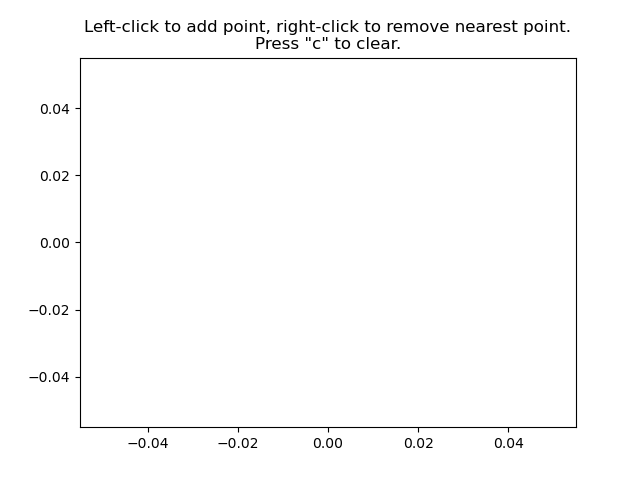

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Close any existing figures
plt.close('all')

class PointSelector:
    def __init__(self):
        # Initialize the plot
        self.fig, self.ax = plt.subplots()
        self.points = np.empty((0, 2))  # Array to store point coordinates
        self.scatter = self.ax.scatter([], [])
        
        # Connect event handlers
        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.cid_key = self.fig.canvas.mpl_connect('key_press_event', self.onkeypress)
        
        # Set the plot title
        self.ax.set_title('Left-click to add point, right-click to remove nearest point.\nPress "c" to clear.')

    def onclick(self, event):
        """Handle mouse click events."""
        if event.inaxes != self.ax:
            return  # Ignore clicks outside the plot area

        x, y = event.xdata, event.ydata

        if event.button == 1:
            # Left-click: Add a point
            self.points = np.vstack([self.points, [x, y]])
            self.update_plot()
        elif event.button == 3:
            # Right-click: Remove the nearest point
            if self.points.size > 0:
                distances = np.hypot(self.points[:, 0] - x, self.points[:, 1] - y)
                idx = np.argmin(distances)
                self.points = np.delete(self.points, idx, axis=0)
                self.update_plot()

    def onkeypress(self, event):
        """Handle key press events."""
        if event.key == 'c':
            # Press 'c' to clear all points
            self.points = np.empty((0, 2))
            self.update_plot()

    def update_plot(self):
        """Update the scatter plot with the current points."""
        self.scatter.set_offsets(self.points)
        self.fig.canvas.draw_idle()

    def show(self):
        """Display the plot."""
        plt.show()

# Create an instance of PointSelector and display the plot
selector = PointSelector()
selector.show()


<IPython.core.display.Javascript object>


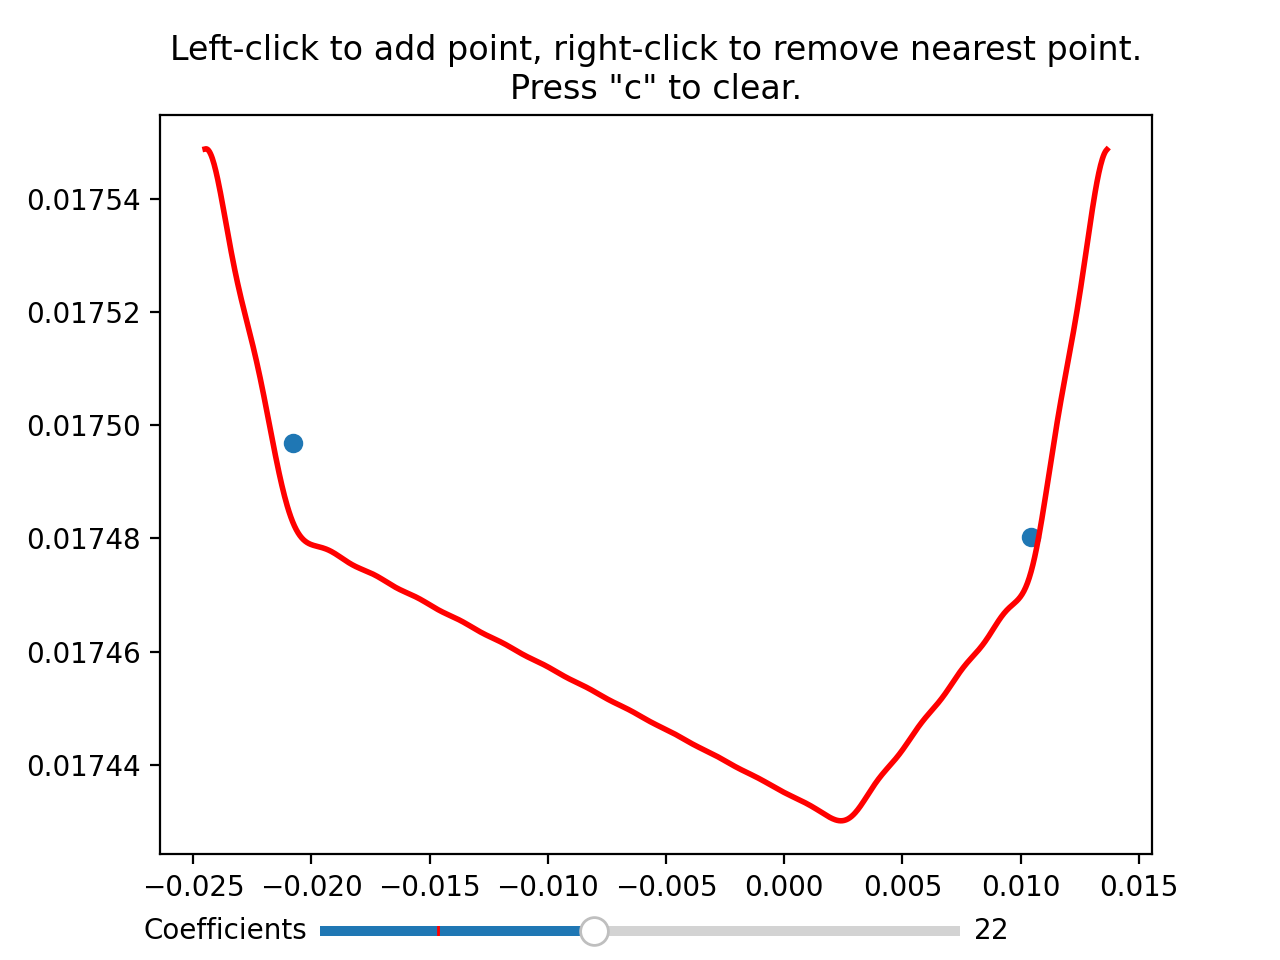

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

# Close any existing figures
plt.close('all')

class PointSelectorWithFourier:
    def __init__(self):
        # Initialize the plot
        self.fig, self.ax = plt.subplots()
        self.points = np.empty((0, 2))  # Array to store point coordinates
        self.scatter = self.ax.scatter([], [])
        self.line, = self.ax.plot([], [], 'r-', lw=2)  # Line for Fourier fit

        # Initialize the slider
        self.ax_slider = self.fig.add_axes([0.25, 0.02, 0.5, 0.02])
        self.slider = Slider(self.ax_slider, 'Coefficients', 1, 50, valinit=10, valstep=1)
        self.slider.on_changed(self.update_fourier)

        # Connect event handlers
        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.cid_key = self.fig.canvas.mpl_connect('key_press_event', self.onkeypress)

        # Set the plot title
        self.ax.set_title('Left-click to add point, right-click to remove nearest point.\nPress "c" to clear.')
    
    def onclick(self, event):
        """Handle mouse click events."""
        if event.inaxes != self.ax:
            return  # Ignore clicks outside the plot area

        x, y = event.xdata, event.ydata

        if event.button == 1:
            # Left-click: Add a point
            self.points = np.vstack([self.points, [x, y]])
            self.update_plot()
        elif event.button == 3:
            # Right-click: Remove the nearest point
            if self.points.size > 0:
                distances = np.hypot(self.points[:, 0] - x, self.points[:, 1] - y)
                idx = np.argmin(distances)
                self.points = np.delete(self.points, idx, axis=0)
                self.update_plot()

    def onkeypress(self, event):
        """Handle key press events."""
        if event.key == 'c':
            # Press 'c' to clear all points
            self.points = np.empty((0, 2))
            self.update_plot()

    def update_plot(self):
        """Update the scatter plot with the current points."""
        self.scatter.set_offsets(self.points)
        self.update_fourier(None)  # Update the Fourier fit
        self.fig.canvas.draw_idle()

    def update_fourier(self, val):
        """Update the Fourier fit line based on the number of coefficients."""
        if self.points.shape[0] < 2:
            # Not enough points to perform Fourier transform
            self.line.set_data([], [])
            self.fig.canvas.draw_idle()
            return

        # Number of coefficients from the slider
        n_coeffs = int(self.slider.val)

        # Sort points by x-coordinate
        sorted_points = self.points[self.points[:, 0].argsort()]
        x = sorted_points[:, 0]
        y = sorted_points[:, 1]

        # Create a uniform x-array for fitting
        x_uniform = np.linspace(x.min(), x.max(), 1000)

        # Interpolate y-values at uniform x positions
        y_interp = np.interp(x_uniform, x, y)

        # Perform Fourier Transform
        y_fft = np.fft.fft(y_interp)
        # Zero out all but the first n_coeffs coefficients
        y_fft_filtered = np.zeros_like(y_fft)
        y_fft_filtered[:n_coeffs] = y_fft[:n_coeffs]
        # Perform Inverse Fourier Transform
        y_ifft = np.fft.ifft(y_fft_filtered).real

        # Update the line data
        self.line.set_data(x_uniform, y_ifft)
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw_idle()

    def show(self):
        """Display the plot."""
        plt.show()

# Create an instance of PointSelectorWithFourier and display the plot
selector = PointSelectorWithFourier()
selector.show()


<IPython.core.display.Javascript object>


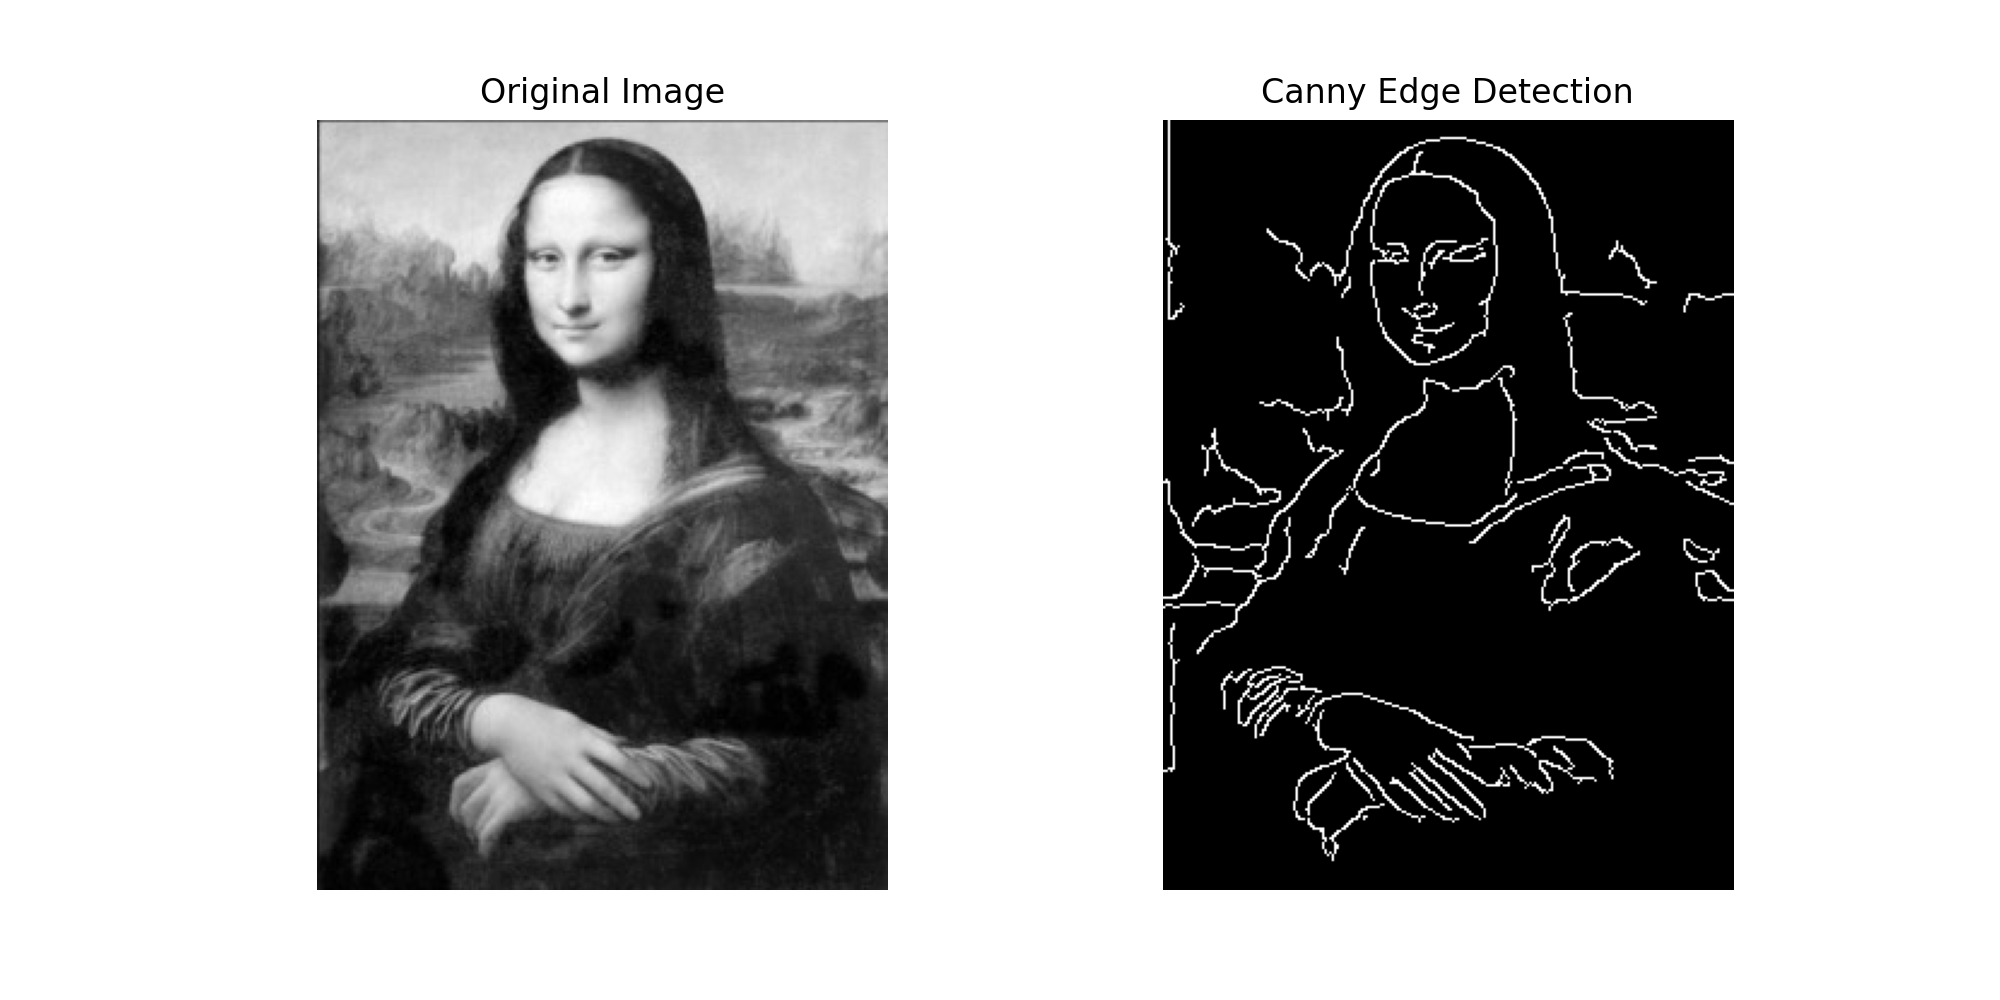

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/Users/sabiangrier/Desktop/Undergrad/5725 Final Project/Mona_Lisa.jpeg", cv2.IMREAD_GRAYSCALE)

# Check if image is loaded successfully
if image is None:
    print("Error: Could not load image.")
    exit()

# Apply Gaussian blur to reduce noise and improve edge detection
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)

# Apply Canny edge detection
# Adjust the threshold values as needed
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Display the original and edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Canny Edge Detection")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.show()


<IPython.core.display.Javascript object>


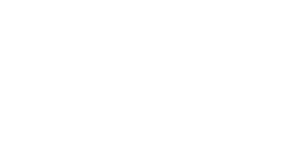

<IPython.core.display.Javascript object>


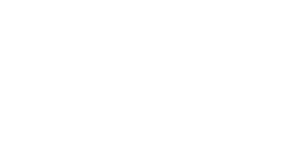

<IPython.core.display.Javascript object>


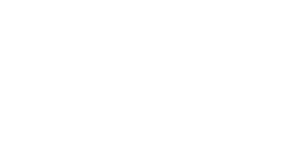

<IPython.core.display.Javascript object>


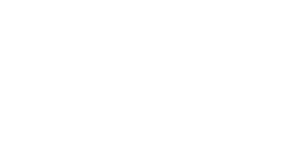

<IPython.core.display.Javascript object>


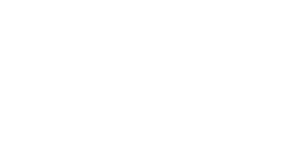

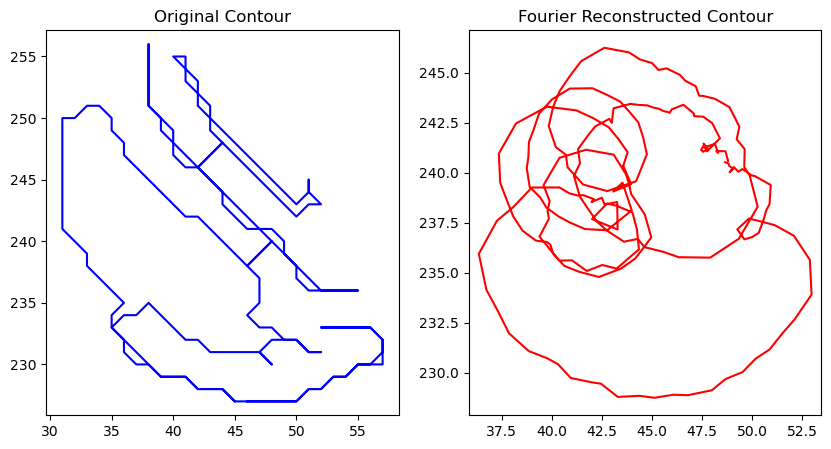

In [6]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image and apply Canny edge detection
image = cv2.imread("/Users/sabiangrier/Desktop/Undergrad/5725 Final Project/Mona_Lisa.jpeg", cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)
edges = cv2.Canny(blurred_image, 50, 150)

# Step 2: Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Choose the largest contour (if desired) to simplify
contour = max(contours, key=cv2.contourArea).squeeze()

# Step 3: Prepare points for Fourier Transform
# Convert to complex numbers (x + iy)
complex_contour = np.array([complex(pt[0], pt[1]) for pt in contour])

# Step 4: Perform Fourier Transform
fourier_transform = np.fft.fft(complex_contour)

# Step 5: Reconstruct shape using only top frequencies (e.g., top 100)
num_coefficients = 100  # You can adjust the number of coefficients for more/less detail
filtered_transform = np.zeros_like(fourier_transform)
filtered_transform[:num_coefficients] = fourier_transform[:num_coefficients]

# Step 6: Inverse Fourier Transform to reconstruct
reconstructed_contour = np.fft.ifft(filtered_transform)

# Step 7: Plot original and Fourier-reconstructed contours
plt.figure(figsize=(10, 5))

# Plot original contour
plt.subplot(1, 2, 1)
plt.plot(contour[:, 0], contour[:, 1], color='blue')
plt.title("Original Contour")
plt.axis("equal")

# Plot Fourier-reconstructed contour
plt.subplot(1, 2, 2)
plt.plot(reconstructed_contour.real, reconstructed_contour.imag, color='red')
plt.title("Fourier Reconstructed Contour")
plt.axis("equal")

plt.show()


In [2]:
def read_pgm(filename):
    with open(filename, 'rb') as f:
        # Read magic number (P5)
        header = f.readline()
        assert header.strip() == b'P5', 'Not a PGM file'
        
        # Read image size
        while True:
            line = f.readline()
            if line[0] != ord('#'):
                width, height = map(int, line.strip().split())
                break
        
        # Read max gray value
        max_gray = int(f.readline().strip())
        assert max_gray <= 255, 'Only 8-bit PGM files are supported'
        
        # Read pixel data
        data = f.read()
        image = [[data[i * width + j] for j in range(width)] for i in range(height)]
        return image

import math

def gaussian_kernel(size, sigma=1):
    kernel = [[0 for _ in range(size)] for _ in range(size)]
    offset = size // 2
    sum_val = 0
    for x in range(size):
        for y in range(size):
            x0 = x - offset
            y0 = y - offset
            value = (1 / (2 * math.pi * sigma ** 2)) * math.exp(-(x0 ** 2 + y0 ** 2) / (2 * sigma ** 2))
            kernel[x][y] = value
            sum_val += value
    # Normalize the kernel
    for x in range(size):
        for y in range(size):
            kernel[x][y] /= sum_val
    return kernel

def convolve(image, kernel):
    height = len(image)
    width = len(image[0])
    k_size = len(kernel)
    offset = k_size // 2
    new_image = [[0 for _ in range(width)] for _ in range(height)]
    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            acc = 0
            for ki in range(k_size):
                for kj in range(k_size):
                    ii = i + ki - offset
                    jj = j + kj - offset
                    acc += image[ii][jj] * kernel[ki][kj]
            new_image[i][j] = acc
    return new_image

def sobel_filters(image):
    Kx = [[-1, 0, 1],
          [-2, 0, 2],
          [-1, 0, 1]]
    Ky = [[-1, -2, -1],
          [ 0,  0,  0],
          [ 1,  2,  1]]
    
    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)
    
    G = [[0 for _ in range(len(Ix[0]))] for _ in range(len(Ix))]
    theta = [[0 for _ in range(len(Ix[0]))] for _ in range(len(Ix))]
    
    for i in range(len(Ix)):
        for j in range(len(Ix[0])):
            G[i][j] = math.hypot(Ix[i][j], Iy[i][j])
            theta[i][j] = math.atan2(Iy[i][j], Ix[i][j])
    
    return G, theta

def non_max_suppression(G, theta):
    height = len(G)
    width = len(G[0])
    Z = [[0 for _ in range(width)] for _ in range(height)]
    angle = [[0 for _ in range(width)] for _ in range(height)]
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            # Angle normalization
            angle = theta[i][j] * 180.0 / math.pi
            angle = angle if angle >= 0 else angle + 180
            
            q = 255
            r = 255
            
            # Determine neighbors based on the gradient direction
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = G[i][j+1]
                r = G[i][j-1]
            elif (22.5 <= angle < 67.5):
                q = G[i+1][j-1]
                r = G[i-1][j+1]
            elif (67.5 <= angle < 112.5):
                q = G[i+1][j]
                r = G[i-1][j]
            elif (112.5 <= angle < 157.5):
                q = G[i-1][j-1]
                r = G[i+1][j+1]
            
            # Suppress non-maximum pixels
            if G[i][j] >= q and G[i][j] >= r:
                Z[i][j] = G[i][j]
            else:
                Z[i][j] = 0
    return Z

def threshold(image, low_ratio=0.05, high_ratio=0.15):
    max_val = max(map(max, image))
    high_threshold = max_val * high_ratio
    low_threshold = high_threshold * low_ratio
    height = len(image)
    width = len(image[0])
    res = [[0 for _ in range(width)] for _ in range(height)]
    weak = 25
    strong = 255
    
    for i in range(height):
        for j in range(width):
            pixel = image[i][j]
            if pixel >= high_threshold:
                res[i][j] = strong
            elif pixel >= low_threshold:
                res[i][j] = weak
            else:
                res[i][j] = 0
    return res, weak, strong

def hysteresis(image, weak, strong=255):
    height = len(image)
    width = len(image[0])
    for i in range(1, height-1):
        for j in range(1, width-1):
            if image[i][j] == weak:
                # Check if any neighbor is a strong pixel
                if any(image[i+a][j+b] == strong for a in [-1,0,1] for b in [-1,0,1]):
                    image[i][j] = strong
                else:
                    image[i][j] = 0
    return image


In [3]:
import cv2

# Read the image in grayscale mode
img = cv2.imread('/Users/sabiangrier/Desktop/Bird_Image.jpeg', cv2.IMREAD_GRAYSCALE)

# Save the image in PGM format
cv2.imwrite('output_image.pgm', img)

True

In [4]:
# Read the image
image = read_pgm('output_image.pgm')

# Step 1: Gaussian Blur
kernel = gaussian_kernel(size=5, sigma=1)
smoothed_image = convolve(image, kernel)

# Step 2: Compute Gradients
gradient_magnitude, gradient_direction = sobel_filters(smoothed_image)

# Step 3: Non-Maximum Suppression
non_max_image = non_max_suppression(gradient_magnitude, gradient_direction)

# Step 4: Double Thresholding
threshold_image, weak_pixel, strong_pixel = threshold(non_max_image)

# Step 5: Edge Tracking by Hysteresis
final_image = hysteresis(threshold_image, weak_pixel, strong_pixel)

# Save or display the final_image as needed


In [6]:
def write_pgm(filename, image):
    height = len(image)
    width = len(image[0])
    max_gray = 255
    with open(filename, 'wb') as f:
        f.write(f'P5\n{width} {height}\n{max_gray}\n'.encode())
        for row in image:
            f.write(bytearray(row))

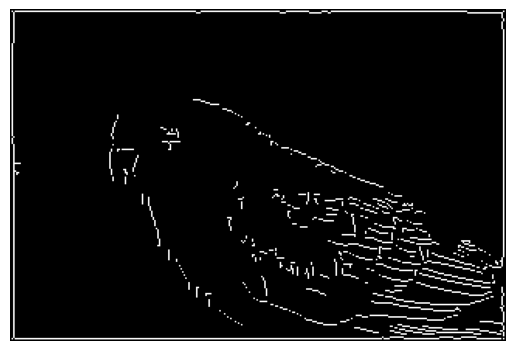

In [9]:
import cv2
from matplotlib import pyplot as plt

# Read the PGM image
image = cv2.imread('output.pgm', cv2.IMREAD_GRAYSCALE)

# Display the image using Matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

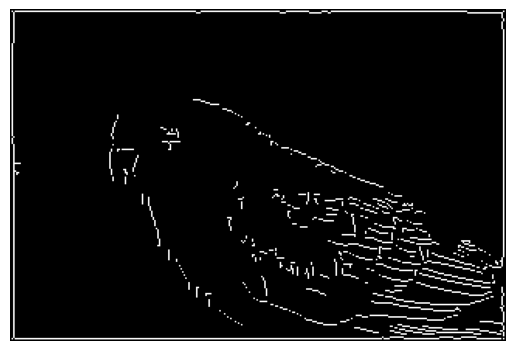

In [8]:
import cv2
from matplotlib import pyplot as plt

# Read the PGM image
image = cv2.imread('output.pgm', cv2.IMREAD_GRAYSCALE)

# Display the image using Matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()